## Loading Data

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
Rs = 100 # shield resistor 100 ohm
Rp = 10000 # plate resistor 10000 ohm

In [41]:
data = np.loadtxt("goodData 20-10-2021.txt", skiprows=2, delimiter=", ")

vin, vp, dvp, vs, dvs = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]

i_s = vs/Rs
di_s = dvs/Rs

i_p = vp/Rp
di_p = dvp/Rp

# input voltage, plate voltage, uncertainty on plate voltage,
# shield voltage, uncertainty on shield voltage

In [42]:
frozendata = np.loadtxt("nitrodata.txt", skiprows=2, delimiter=", ")

# 'f' for frozen
fvin, fvp, fvs = frozendata[:,0], frozendata[:,1], frozendata[:,2]

#uncertainty on plate voltage was always 0.1e-03 V
dfvp = 0.1e-03 * np.ones(len(fvp))

#V_s uncertainties were 0.1e-03 except the last 4, which were an order of mag higher
dfvs = 0.1e-03 * np.ones(len(fvs) - 4)
dfvs = np.append(dfvs, [1e-03, 1e-03, 1e-03, 1e-03])

# frozen currents

fi_p = fvp/Rp
dfi_p = dfvp/Rp

fi_s = fvs/Rs
dfi_s = dfvs/Rs

In [78]:
reversedata = np.loadtxt("reversedata.txt", skiprows=2, delimiter=", ")

# 'r' for reverse
rvin, rvp, rvs = reversedata[:,0], 1e-03*reversedata[:,1], 1e-03*reversedata[:,2]

# uniform uncertainties on each reading of reverse voltages
drvp = 0.1e-03 * np.ones(len(rvp))
drvs = 0.1e-03 * np.ones(len(rvs))

print(rvin, rvs)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45] [0.0027 0.002  0.0014 0.0009 0.0006 0.0003 0.0002 0.0001 0.     0.    ]


## Finding $V_c$

Some of the readings for shield current were zero. Since I had to do a log plot of these values, I had to simply ignore these values of zero, as log(0) is invalid. 

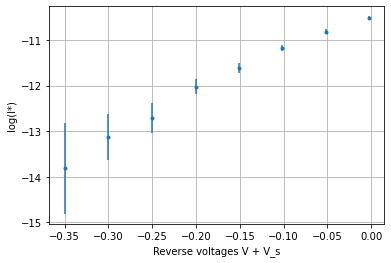

In [79]:
zeroes = np.where(rvs == 0) # Finding the zeros in the shield current array

correctrvs = np.delete(rvs, zeroes)
correctdrvs = np.delete(drvs, zeroes)

correctrvin = np.delete(rvin, zeroes) # shape of this array needs to be the same, so graphing is possible

# finding currents with Ohm's Law
ri_s = correctrvs/Rs # reverse shield current
dri_s = correctdrvs/Rs # uncertainty on that, using error propagation formula

# Getting V = -(V + V_s)
V = -1*(correctrvin + correctrvs)
dV = correctdrvs

# Getting logs for the graph
logri_s = np.log(ri_s)
dlogri_s = dri_s/ri_s

plt.errorbar(V, logri_s, yerr = dlogri_s, xerr = dV, fmt='.')
plt.xlabel("Reverse voltages V + V_s")
plt.ylabel("log(I*)")
plt.grid()

In [80]:
import scipy.odr as odr

def linear(params,x):
    m,c = params[0], params[1]
    return m*x + c

def fitting(x, y, xerr, yerr, guessparameters):
    line = odr.Model(linear)
    myData = odr.Data(x,y, wd=1/xerr, we=1/yerr)
    fit = odr.ODR(myData, line, beta0=guessparameters)
    output = fit.run()
    output.pprint()
    print("\n")
    
    m,c = output.beta[0], output.beta[1]
    varm, varc = output.cov_beta[0,0], output.cov_beta[1,1]
    
    return m,c, varm, varc #slope, intercept, variance on slope, variance on intercept

linebestfit = fitting(V,logri_s, dV, dlogri_s, [10,-10.5])

bestfitparams = [linebestfit[0], linebestfit[1]]

Beta: [  8.51674655 -10.41263668]
Beta Std Error: [0.48069357 0.05853482]
Beta Covariance: [[1.91000687 0.16696726]
 [0.16696726 0.02832219]]
Residual Variance: 0.12097668892775372
Inverse Condition #: 0.083528618950584
Reason(s) for Halting:
  Sum of squares convergence




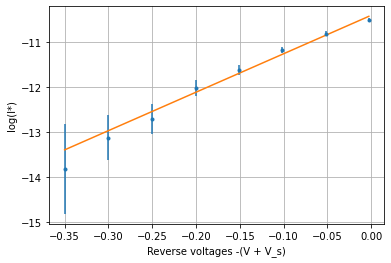

In [96]:
# Plotting the line I just found

plt.errorbar(V, logri_s, yerr = dlogri_s, xerr = dV, fmt='.')
plt.plot(V, linear(bestfitparams,V))
plt.xlabel("Reverse voltages -(V + V_s)")
plt.ylabel("log(I*)")
plt.grid()

It seems that the line starts to turn around V + Vs = -0.10, so I will now fit two lines to the data: one in the range $V + V_s \ \in \ [-0.35, -0.15]$ and another in $V + V_s \ \in \ [-0.15, 0.00]$

all values of V: [-0.0027 -0.052  -0.1014 -0.1509 -0.2006 -0.2503 -0.3002 -0.3501]
first line: x in range [-0.2503 -0.3002 -0.3501]
second line: x in range [-0.0027 -0.052  -0.1014 -0.1509 -0.2006]



Beta: [ 10.44826515 -10.072374  ]
Beta Std Error: [1.73195458 0.49585214]
Beta Covariance: [[123.18924482  34.96887855]
 [ 34.96887855  10.0972748 ]]
Residual Variance: 0.02435006935351497
Inverse Condition #: 0.029827869386592796
Reason(s) for Halting:
  Sum of squares convergence


Beta: [  7.47967291 -10.46694221]
Beta Std Error: [0.34968313 0.03292318]
Beta Covariance: [[3.58868175 0.24900306]
 [0.24900306 0.03181187]]
Residual Variance: 0.034073316434606205
Inverse Condition #: 0.06283048745555639
Reason(s) for Halting:
  Sum of squares convergence


123.18924481693787 10.097274800225081


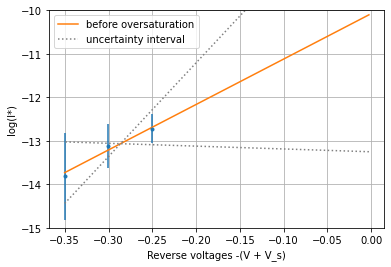

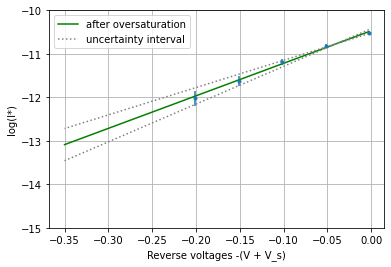

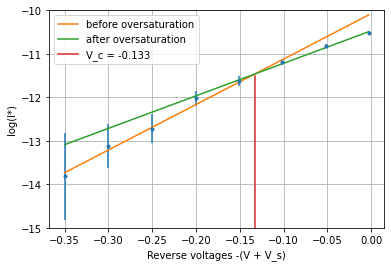

V_c is the x-coordinate where the two lines intersect
V_c = -0.13291
uncertainty on V_c is +/- 1.18471


In [98]:
range1args = np.array(np.where(V <= -0.25))
range2args = np.array(np.where(V >= -0.25))
min1, max1 = range1args[0,0], range1args[0,-1]+1
min2, max2 = range2args[0,0], range2args[0,-1]+1

print("all values of V: " + str(V))
print("first line: x in range " + str(V[min1:max1]))
print("second line: x in range " + str(V[min2:max2]))
print("\n\n")

line1 = fitting(V[min1:max1], logri_s[min1:max1], dV[min1:max1], dlogri_s[min1:max1], [10,-10])
line2 = fitting(V[min2:max2], logri_s[min2:max2], dV[min2:max2], dlogri_s[min2:max2], [6,-10.5])

m1, c1, varm1, varc1 = line1
m2, c2, varm2, varc2 = line2

print(varm1, varc1)

# V_c is the x-value of where the lines intersect
Vc = (c2 - c1) / (m1 - m2)
ycross = m1*Vc + c1 # finding the y value of the intersection point
# creating an x and y range for plotting
y_axis = np.arange(-16,ycross, 0.1) 
xcross = Vc * np.ones(len(y_axis))

# manual adjustments of the errors on the slopes and intercepts 
#varm1, varc1 = 130, 10
#varm2, varc2 = 1.2, 0.05

#Error on V_c by error propagation
Vc_err = np.sqrt((varc1 + varc2)/((m1-m2)**2) + ( (c1-c2)/((m1-m2)**2) )**2 * (varm1 + varm2) )

# Plotting the line before oversaturation 
plt.errorbar(V[min1:max1], logri_s[min1:max1], yerr = dlogri_s[min1:max1], xerr = dV[min1:max1], fmt='.')
plt.plot(V, linear([m1,c1],V), label="before oversaturation")
plt.plot(V, linear([m1+np.sqrt(varm1),c1+np.sqrt(varc1)],V),color='gray',linestyle='dotted', label = "uncertainty interval")
plt.plot(V, linear([m1-np.sqrt(varm1),c1-np.sqrt(varc1)],V),color='gray',linestyle='dotted')

plt.xlabel("Reverse voltages -(V + V_s)")
plt.ylabel("log(I*)")
plt.ylim(-15,-10)
plt.legend()
plt.grid()
plt.show()
######

# Plotting the line after oversaturation #
plt.errorbar(V[min2:max2], logri_s[min2:max2], yerr = dlogri_s[min2:max2], xerr = dV[min2:max2], fmt='.')
plt.plot(V, linear([m2,c2],V), label="after oversaturation", color='green')
plt.plot(V, linear([m2+1.2,c2+0.05],V),color='gray',linestyle='dotted', label = "uncertainty interval")
plt.plot(V, linear([m2-1.2,c2-0.05],V),color='gray',linestyle='dotted')

plt.xlabel("Reverse voltages -(V + V_s)")
plt.ylabel("log(I*)")
plt.ylim(-15,-10)
plt.legend()
plt.grid()
plt.show()
######

# Plotting both lines, finding intersection #
plt.errorbar(V, logri_s, yerr = dlogri_s, xerr = dV, fmt='.')
plt.plot(V, linear([m1,c1],V), label="before oversaturation")
plt.plot(V, linear([m2,c2],V), label="after oversaturation")
plt.plot(xcross, y_axis, label="V_c = %.3f"%Vc)
#plt.plot(xcross + Vc_err, y_axis,color='gray',linestyle='dotted', label = "uncertainty interval for V_c")
#plt.plot(xcross - Vc_err, y_axis,color='gray',linestyle='dotted')

plt.xlabel("Reverse voltages -(V + V_s)")
plt.ylabel("log(I*)")
plt.ylim(-15,-10)
plt.legend()
plt.grid()
plt.show()
######

# Showing where the massive error on V_c comes from #
#plt.errorbar(V, logri_s, yerr = dlogri_s, xerr = dV, fmt='.')

#plt.plot(V, linear([m1+np.sqrt(varm1),c1+np.sqrt(varc1)],V),color='orange',linestyle='dotted')
#plt.plot(V, linear([m1-np.sqrt(varm1),c1-np.sqrt(varc1)],V),color='orange',linestyle='dotted')

#plt.plot(V, linear([m2+np.sqrt(varm2),c2+np.sqrt(varc2)],V),color='green',linestyle='dotted')
#plt.plot(V, linear([m2-np.sqrt(varm2),c2-np.sqrt(varc2)],V),color='green',linestyle='dotted')

#plt.plot(xcross, y_axis, label="V_c = %.3f"%Vc, color='red')
#plt.plot(xcross + Vc_err, y_axis,color='gray',linestyle='dashed')
#plt.plot(xcross - Vc_err, y_axis,color='gray',linestyle='dashed')

#plt.xlabel("Reverse voltages V + V_s")
#plt.ylabel("log(I*)")
#plt.ylim(-15,-10)
#plt.legend()
#plt.grid()
#plt.show()
######

print("V_c is the x-coordinate where the two lines intersect\nV_c = %.5f" %Vc)
print("uncertainty on V_c is +/- %.5f" %Vc_err)

## Finding $\bar{V}$

$$ 
    log I = log I_0 - \frac{3}{2\bar{V}}(-(V + V_s))
$$

$$
\bar{V} = \frac{3}{2(slope)}
$$

In [102]:
vbar = 3/(2 * m1)
dvbar = np.sqrt( (-3/(2 * m1**2))**2 * (varm1))

print("V bar = %.5f +/- " %vbar , "%.5f" %dvbar)

V bar = 0.14356 +/-  0.15251


## Plotting $P_s$ vs $V$

0.9525999420293341 0.6273988151507235


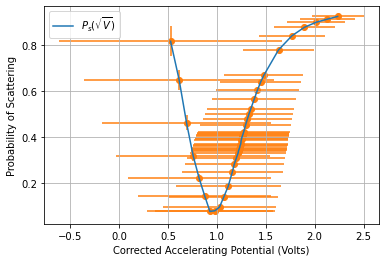

In [122]:
Ps = 1 - (i_p * fi_s)/(i_s * fi_p)

numerator = (i_p * fi_s)
denominator = (i_s * fi_p)

varnumerator = i_p**2 * dfi_s**2 + di_p**2 * fi_s**2
vardenominator = fi_p**2 * di_s**2 + dfi_p**2 * i_s**2

dPs = np.sqrt(varnumerator/denominator**2 + (numerator/denominator)**2 * vardenominator/denominator**2)
#dPs = np.sqrt( (fi_s * di_p)**2 + (fi_p))

V = vin - vs - Vc + vbar
rootV = np.sqrt(V)
dV = np.sqrt(dvs**2 + Vc_err**2 + dvbar**2)
drootV = dV/(2*rootV)

plt.plot(rootV, Ps, zorder=2, label="$P_s (\sqrt{V})$")
plt.errorbar(rootV, Ps, xerr=drootV, yerr=dPs, fmt='o', zorder=1)
plt.ylabel("Probability of Scattering")
plt.xlabel("Corrected Accelerating Potential (Volts)")
plt.legend()
plt.grid()

print((rootV[6] + rootV[7])/2, (drootV[6] + drootV[7])/2)

Minimum Ps at $ \sqrt{V} = 0.953 \ \pm \ 0.627 $